# 0. Чувствительность решающих деревьев

In [1]:
import pydotplus 
import random
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

https://scikit-learn.org/stable/modules/ensemble.html

https://scikit-learn.org/stable/api/sklearn.ensemble.html

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target

In [3]:
train_data, test_data, train_target, test_target = (train_test_split(X, y, test_size=0.2, random_state=0))

In [4]:
model = DecisionTreeClassifier()
model.fit(train_data, train_target)

DecisionTreeClassifier()

In [5]:
train_predictions = model.predict(train_data)
test_predictions = model.predict(test_data)

In [6]:
print(accuracy_score(train_target, train_predictions))
print(accuracy_score(test_target, test_predictions))

1.0
0.9035087719298246


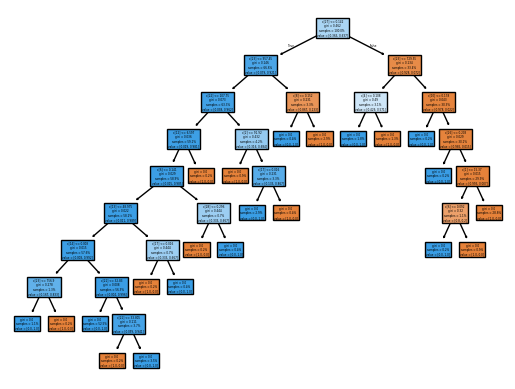

In [7]:
plot_tree(model, proportion=True, filled=True)
plt.show()

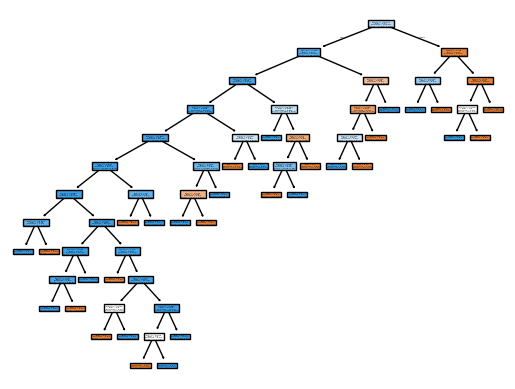

In [8]:
noise_size = 10
random_gen = random.Random(42)

train_target_noise = [random_gen.randint(0, 1) for _ in range(noise_size)] + list(train_target[noise_size:])

model.fit(train_data, train_target_noise)

plot_tree(model, proportion=True, filled=True)
plt.show()

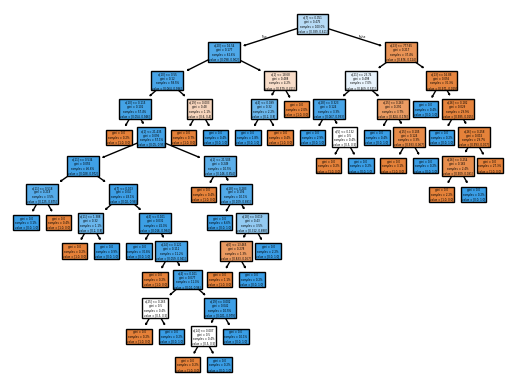

In [9]:
noise_size = 20
random_gen = random.Random(42)

train_target_noise = [random_gen.randint(0, 1) for _ in range(noise_size)] + list(train_target[noise_size:])

model.fit(train_data, train_target_noise)

plot_tree(model, proportion=True, filled=True)
plt.show()

# 1. Бэггинг над решающими деревьями

In [10]:
d3 = DecisionTreeClassifier()
rnd_d3 = DecisionTreeClassifier(max_features=int(len(X) ** 0.5)) # Решающее дерево с рандомизацией в сплитах

In [11]:
print("Decision tree:", cross_val_score(d3, X, y).mean())

Decision tree: 0.9208818506443098


In [12]:
print("D3 bagging:", cross_val_score(BaggingClassifier(d3), X, y).mean())

D3 bagging: 0.9455519329296692


In [13]:
print("Randomized D3 bagging:", cross_val_score(BaggingClassifier(rnd_d3), X, y).mean())

Randomized D3 bagging: 0.9455519329296692


In [14]:
print("Random Forest:", cross_val_score(RandomForestClassifier(random_state=42), X, y).mean())

Random Forest: 0.9560937742586555


# 2. Бустинг над решающими деревьями

In [15]:
print(f"AdaBoostClassifier: {cross_val_score(AdaBoostClassifier(algorithm='SAMME'), X, y).mean():.4f}")

AdaBoostClassifier: 0.9684


https://catboost.ai/docs/en/concepts/python-usages-examples

In [16]:
print(f"CatBoostClassifier: {cross_val_score(CatBoostClassifier(verbose=False), X, y).mean():.4f}")

CatBoostClassifier: 0.9719


# 3. Зависимость качества от количества деревьев

In [17]:
n_trees = [1] + list(range(5, 105, 5))

In [18]:
%%time
scoring = []
for n_tree in n_trees:
    estimator = RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1)
    score = cross_val_score(estimator, X, y)    
    scoring.append(score)
scoring = np.asmatrix(scoring)

CPU times: user 6.2 s, sys: 6.6 ms, total: 6.2 s
Wall time: 6.21 s


In [19]:
%%time
catboost_scoring = []
for n_tree in n_trees:
    estimator = CatBoostClassifier(max_depth=6, n_estimators=n_tree, verbose=False)
    score = cross_val_score(estimator, X, y) 
    catboost_scoring.append(score)
catboost_scoring = np.asmatrix(catboost_scoring)

CPU times: user 1min 18s, sys: 8.89 s, total: 1min 27s
Wall time: 7 s


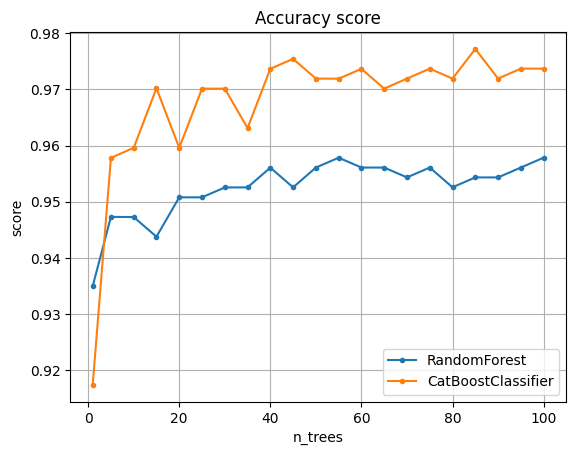

In [20]:
plt.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
plt.plot(n_trees, catboost_scoring.mean(axis = 1), marker='.', label='CatBoostClassifier')
plt.grid(True)
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc='lower right');

# 4. CatBoost всё ещё деревья

In [21]:
def foo(x, mean=0, std=1):
    return 2 * x + 4 + np.random.normal(mean, std, size=x.shape)


train_size = 50
X_reg = np.random.uniform(low=-2, high=2, size=train_size)
y_reg = foo(X_reg, 0, 0)

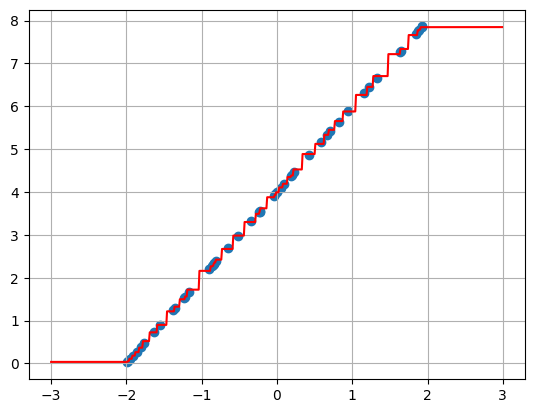

In [22]:
reg = CatBoostRegressor(verbose=False).fit(X_reg, y_reg)

X_test = np.arange(-3, 3, 0.01)
y_pred = reg.predict(X_test.reshape(-1, 1))

plt.scatter(X_reg, y_reg)
plt.plot(X_test, y_pred, 'r')
plt.grid()

# 5. Стэкинг

In [23]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42))),
    ('knn', KNeighborsClassifier())
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [24]:
print(f"StackingClassifier: {cross_val_score(clf, X, y).mean():.4f}")

StackingClassifier: 0.9719


# 6. Оценка bias и variance

Пусть у нас есть алгоритм обучения, который по данным может создать модель.

Ошибка этих моделей может быть разложена на три части:
* **Noise** – шум данных, не предсказуем, теоретический минимум ошибки
* **Bias** – смещение, на сколько хорошо работает средний алгоритм. Средний алгоритм это "возьмём случайные данные, обучим алгоритм, сделаем предсказания", **Bias** – это ошибка средних предсказаний.
* **Variance** – разброс, на сколько устойчиво работает алгоритм. Опять же "возьмём случайные данные, обучим алгоритм, сделаем предсказания", **Variance** – это разрос этих предсказаний.

In [70]:
X_train, X_test, y_train, y_test = (train_test_split(X, y, test_size=0.2, random_state=0))

In [75]:
def sample_model(seed, model):
    random_gen = np.random.RandomState(seed)
    indices = random_gen.choice(len(y_train), size=len(y_train), replace=True)
    model.fit(X_train[indices, :], y_train[indices])
    return model

def estimate_bias_variance(model, iters_count=100):
    y_preds = []
    for seed in range(iters_count):
        model = sample_model(seed, model)
        y_preds.append(model.predict(X_test))
    y_preds = np.array(y_preds)
    
    print('Bias:', np.mean((y_test - y_preds.mean(axis=0)) ** 2))
    print('Variance:', y_preds.std(axis=0).mean())

**Решающее дерево с max_depth=2**

In [76]:
estimate_bias_variance(DecisionTreeClassifier(max_depth=2))

Bias: 0.028867543859649125
Variance: 0.10187242589657358


**Решающее дерево с max_depth=4**

In [77]:
estimate_bias_variance(DecisionTreeClassifier(max_depth=4))

Bias: 0.02823245614035088
Variance: 0.11452703267388017


**Решающее дерево с max_depth=6**

In [78]:
estimate_bias_variance(DecisionTreeClassifier(max_depth=6))

Bias: 0.02827631578947368
Variance: 0.1270802674339382


**Решающее дерево без ограничения глубины**

In [79]:
estimate_bias_variance(DecisionTreeClassifier(max_depth=None))

Bias: 0.03060263157894737
Variance: 0.13167865881540478


**Случайный лес n_estimators=1**

In [80]:
estimate_bias_variance(RandomForestClassifier(n_estimators=1, random_state=42))

Bias: 0.02675350877192982
Variance: 0.13972420219243506


**Случайный лес n_estimators=10**

In [81]:
estimate_bias_variance(RandomForestClassifier(n_estimators=10, random_state=42))

Bias: 0.03181315789473685
Variance: 0.05741850026443158


**Случайный лес n_estimators=50**

In [82]:
estimate_bias_variance(RandomForestClassifier(n_estimators=50, random_state=42))

Bias: 0.03142017543859649
Variance: 0.04364086296170743


In [84]:
estimate_bias_variance(CatBoostClassifier(n_estimators=1, max_depth=6, verbose=False))

Bias: 0.0461078947368421
Variance: 0.11463882110428872


In [85]:
estimate_bias_variance(CatBoostClassifier(n_estimators=10, max_depth=6, verbose=False))

Bias: 0.02576140350877193
Variance: 0.056337873961520075


In [86]:
estimate_bias_variance(CatBoostClassifier(n_estimators=100, max_depth=6, verbose=False))

Bias: 0.02121666666666667
Variance: 0.04194577844118346
